In [1]:
import torch
from torch.nn import Upsample, AvgPool3d ,AvgPool2d, Module, Sequential, ModuleList, Conv2d, MaxPool2d, Tanh, ReLU, LeakyReLU, Flatten, Linear, Sigmoid, ConvTranspose2d, BatchNorm2d
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
from tqdm import tqdm
from matplotlib import pyplot as plt
from torchsummary import summary
from torch.nn.utils import spectral_norm

torch.autograd.set_detect_anomaly(True)

# Initialization parameters
device = 'cuda:0'
datapath = '/home/adarsh/ADRL/datasets/bitmoji_faces'
modelpath = '/home/adarsh/ADRL/assignment_1/GAN/proGAN.pt'
modelpath2 = '/home/adarsh/ADRL/assignment_1/GAN/proGAN_l2.pt'
modelpath3 = '/home/adarsh/ADRL/assignment_1/GAN/proGAN_l3.pt'

/home/adarsh/anaconda3/envs/mtech-ai/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class GeneratorBlock(Module):

    def __init__(self, in_channels, out_channels) -> None:
        super(GeneratorBlock, self).__init__()
        self.conv1 = ConvTranspose2d(in_channels, out_channels, 2, 2)
        self.conv2 = Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn1 = BatchNorm2d(out_channels)
        self.conv3 = Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = BatchNorm2d(out_channels)
    
    def forward(self, input):
        h = self.conv1(input)
        h = torch.nn.functional.leaky_relu(self.bn1(self.conv2(h)), 0.2, True)
        h = torch.nn.functional.leaky_relu(self.bn2(self.conv3(h)), 0.2, True)
        return h

class Generator(Module):

    def __init__(self) -> None:
        super(Generator, self).__init__()
        self.conv1 = ConvTranspose2d(512, 512, 4, 4)
        self.conv2 = Conv2d(512, 512, 3, padding=1)
        self.conv3 = Conv2d(512, 512, 3, padding=1)
        self.blocks = ModuleList()
        self.rgb = Conv2d(512, 3, 1)
        self.upsample = Upsample((512, 1, 1))
    
    def forward(self, input, alpha=1):
        h = self.conv1(input)
        h = torch.nn.functional.leaky_relu(self.conv2(h), 0.2, True)
        h = torch.nn.functional.leaky_relu(self.conv3(h), 0.2, True)
        if len(self.blocks)>0:
            [ h:= layer(h) for layer in self.blocks[:-1] ]
            h = alpha*torch.tanh(self.rgb(self.blocks[-1](h))) + (1-alpha)*torch.tanh(self.rgb(self.upconv(self.upsample(h))))
        else:
            h = torch.tanh(self.rgb(h))
        return h
    
    def add_block(self, in_channels, out_channels, size):
        self.rgb = Conv2d(out_channels, 3, 1, 1).to(device)
        self.upsample = Upsample((size, size)).to(device)
        self.upconv = Conv2d(in_channels, out_channels, 1, bias=False).to(device)
        self.blocks.append(GeneratorBlock(in_channels, out_channels).to(device))
        pass

model = Generator()
model.add_block(512, 512, 8)
summary(model.cuda(),(512,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       4,194,816
            Conv2d-2            [-1, 512, 4, 4]       2,359,808
            Conv2d-3            [-1, 512, 4, 4]       2,359,808
   ConvTranspose2d-4            [-1, 512, 8, 8]       1,049,088
            Conv2d-5            [-1, 512, 8, 8]       2,359,808
       BatchNorm2d-6            [-1, 512, 8, 8]           1,024
            Conv2d-7            [-1, 512, 8, 8]       2,359,808
       BatchNorm2d-8            [-1, 512, 8, 8]           1,024
    GeneratorBlock-9            [-1, 512, 8, 8]               0
           Conv2d-10              [-1, 3, 8, 8]           1,539
         Upsample-11            [-1, 512, 8, 8]               0
           Conv2d-12            [-1, 512, 8, 8]         262,144
           Conv2d-13              [-1, 3, 8, 8]           1,539
Total params: 14,950,406
Trainable para

In [4]:
class DiscriminatorBlock(Module):

    def __init__(self, in_channels, out_channels) -> None:
        super(DiscriminatorBlock, self).__init__()
        self.conv1 = spectral_norm(Conv2d(in_channels, in_channels, 3, padding=1))
        self.conv2 = spectral_norm(Conv2d(in_channels, out_channels, 3, padding=1))
        self.pooling = AvgPool2d(2, 2)
    
    def forward(self, h):
        h = torch.nn.functional.leaky_relu(self.conv1(h), 0.2, True)
        h = torch.nn.functional.leaky_relu(self.conv2(h), 0.2, True)
        return self.pooling(h)

class Discriminator(Module):

    def __init__(self) -> None:
        super(Discriminator, self).__init__()
        self.rgb = spectral_norm(Conv2d(3, 512, 1, 1))
        self.pool = AvgPool3d(1)
        self.conv1 = spectral_norm(Conv2d(512, 512, 4, 4))
        self.conv2 = spectral_norm(Conv2d(512, 512, 1, 1))
        self.blocks = ModuleList()
        self.flatten = Flatten()
        self.linear = spectral_norm(Linear(512, 1, bias=False))

    def forward(self, input, alpha=1):
        h1 = torch.nn.functional.leaky_relu(self.rgb(input), 0.2, True)
        h2 = self.pool(h1)
        if len(self.blocks) > 0:
            h = alpha*self.blocks[-1](h1) + (1-alpha)*h2
            [ h:= layer(h) for layer in self.blocks[:-1] ]
        else:
            h = h1
        h = torch.nn.functional.leaky_relu(self.conv1(h), 0.2, True)
        h = torch.nn.functional.leaky_relu(self.conv2(h), 0.2, True)
        h = torch.sigmoid(self.linear(self.flatten(h)))
        return h
    
    def add_block(self, in_channels, out_channels):
        self.rgb = spectral_norm(Conv2d(3, in_channels, 1, 1)).to(device)
        kernel = in_channels/out_channels
        self.pool = AvgPool3d((int(kernel),2,2)).to(device)
        self.blocks.append(DiscriminatorBlock(in_channels, out_channels).to(device))

model = Discriminator()
model.add_block(512, 512)
summary(model.cuda(),(3,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 512, 8, 8]           2,048
         AvgPool3d-2            [-1, 512, 4, 4]               0
            Conv2d-3            [-1, 512, 8, 8]       2,359,808
            Conv2d-4            [-1, 512, 8, 8]       2,359,808
         AvgPool2d-5            [-1, 512, 4, 4]               0
DiscriminatorBlock-6            [-1, 512, 4, 4]               0
            Conv2d-7            [-1, 512, 1, 1]       4,194,816
            Conv2d-8            [-1, 512, 1, 1]         262,656
           Flatten-9                  [-1, 512]               0
           Linear-10                    [-1, 1]             512
Total params: 9,179,648
Trainable params: 9,179,648
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.95
Params size (MB): 35.02
Estima

In [5]:
def sample(k):
    return torch.randn((k, 512, 1, 1)).to(device)

def discriminator_epoch(model, x, z, optim, alpha=0.2):
    '''
        Discriminator Loss:
        maximize f = E[log(1-D(G(z)))] + E[log(D(x))]
    '''
    loss = (model[0](model[1](z, alpha), alpha) - model[0](x,alpha)).mean()
    optim.zero_grad()
    loss.backward()
    optim.step()
    # with torch.no_grad():
    #     for param in model[0].parameters():
    #         param.clamp_(-0.1, 0.1)
    return loss


def generator_epoch(model, X, z, optim, alpha=0.2):
    '''
        Generator Loss:
        minimize f = E[log(1-D(G(z)))]
    '''
    loss = -model[0](model[1](z,alpha),alpha).mean()
    optim.zero_grad()
    loss.backward()
    optim.step()
    return loss

In [6]:
bitmoji_transform = transforms.Compose([transforms.Resize((4,4)), transforms.ToTensor()])
bitmoji_transform_2 = transforms.Compose([transforms.Resize((8,8)), transforms.ToTensor()])

dataset = datasets.ImageFolder(root=datapath, transform=bitmoji_transform)
dataset_2 = datasets.ImageFolder(root=datapath, transform=bitmoji_transform_2)

train_dataset = Subset(dataset, torch.arange(300))

model = Sequential(Discriminator(), Generator()).to(device)

try:
    model.load_state_dict(torch.load(modelpath))
except:
    print('incorrect modelpath')

incorrect modelpath


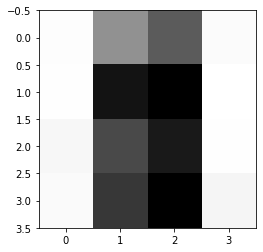

In [22]:
Y = model[1](sample(1)).squeeze()
plt.imshow(Y.detach().cpu().mean(dim=0).squeeze(),'gray')
plt.show()

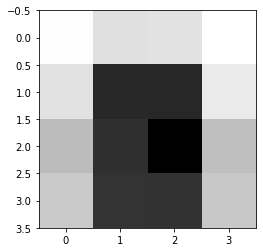

In [9]:
plt.imshow(dataset[5346][0].mean(dim=0).squeeze(),'gray')
plt.show()

In [10]:
i = 0
batch_size = 256
train_dataloader = DataLoader(dataset, batch_size=batch_size)
optim_generator = torch.optim.Adam(model[1].parameters(),lr=0.0001,betas=(0.5,0.999))
optim_discriminator = torch.optim.Adam(model[0].parameters(),lr=0.0001,betas=(0.5,0.999))
finished = 0
for ep in range(1):
    try:
        with tqdm(train_dataloader) as tepoch:
            tepoch.set_description(f'Epoch {ep+1} : ')
            for X, _ in tepoch:
                loss = discriminator_epoch(model, X.to(device), sample(batch_size), optim_discriminator).item(
                ), generator_epoch(model, X.to(device), sample(batch_size), optim_generator).item()
                tepoch.set_postfix({'loss': loss})
                tepoch.refresh()
                i += 1
                if i % 10 == 0:
                    torch.save(model.state_dict(), modelpath)
            if finished:
                break
    except:
        pass


Epoch 1 : : 100%|█████████▉| 508/509 [02:21<00:00,  3.58it/s, loss=(-0.013406169600784779, -0.5231168270111084)]  


In [23]:
model = Sequential(Discriminator(), Generator()).to(device)

try:
    model.load_state_dict(torch.load(modelpath))
except:
    print('incorrect modelpath')

model[0].add_block(512,512)
model[1].add_block(512,512, 8)    

i = 0
batch_size = 256
train_dataloader = DataLoader(dataset_2, batch_size=batch_size)
optim_generator = torch.optim.Adam(model[1].parameters(),lr=0.0001,betas=(0.5,0.999))
optim_discriminator = torch.optim.Adam(model[0].parameters(),lr=0.0001,betas=(0.5,0.999))
alpha = 0
finished = 0
for ep in range(11):
    try:
        with tqdm(train_dataloader) as tepoch:
            tepoch.set_description(f'Epoch {ep+1} : ')
            for X, _ in tepoch:
                if alpha>1:
                    finished=1
                    break
                loss = discriminator_epoch(model, X.to(device), sample(batch_size), optim_discriminator, alpha).item(
                ), generator_epoch(model, X.to(device), sample(batch_size), optim_generator, alpha).item()
                g_loss = loss[1]
                count = 0
                while count <= 4 and g_loss>=-0.6:
                    g_loss = generator_epoch(model, X.to(device), sample(batch_size), optim_generator, alpha).item()
                    count += 1
                tepoch.set_postfix({'loss': loss})
                tepoch.refresh()
                i += 1
                if i % 10 == 0:
                    torch.save(model.state_dict(), modelpath2)
            if finished:
                break
        alpha += 0.2
    except:
        pass



Epoch 10 : :   2%|▏         | 10/509 [00:11<09:25,  1.13s/it, loss=(2.0600855350494385e-06, -0.5026862621307373)]

In [ ]:
model = Sequential(Discriminator(), Generator()).to(device)
model[0].add_block(512,512)
model[1].add_block(512,512, 8)
try:
    model.load_state_dict(torch.load(modelpath2))
except:
    print('incorrect modelpath')

In [ ]:
Y = model[1](sample(1),0).squeeze()
plt.imshow(Y.detach().cpu().mean(dim=0).squeeze(),'gray')
plt.show()

In [ ]:
plt.imshow(dataset_2[5346][0].mean(dim=0).squeeze(),'gray')
plt.show()

In [ ]:
model = Sequential(Discriminator(), Generator()).to(device)
model[0].add_block(512,512)
model[1].add_block(512,512, 8)
try:
    model.load_state_dict(torch.load(modelpath2))
except:
    print('incorrect modelpath')
i = 0
model[0].add_block(512,512)
model[1].add_block(512,512, 16)
batch_size = 128
bitmoji_transform_3 = transforms.Compose([transforms.Resize((16,16)), transforms.ToTensor()])
dataset_3 = datasets.ImageFolder(root=datapath, transform=bitmoji_transform_3)
train_dataloader = DataLoader(dataset_3, batch_size=batch_size)
optim_generator = torch.optim.Adam(model[1].parameters(),lr=0.0001,betas=(0.5,0.999))
optim_discriminator = torch.optim.Adam(model[0].parameters(),lr=0.0001,betas=(0.5,0.999))
alpha = 0
for ep in range(50):
    with tqdm(train_dataloader) as tepoch:
        tepoch.set_description(f'Epoch {ep+1} : ')
        for X, _ in tepoch:
            if alpha > 1:
                break
            loss = discriminator_epoch(model, X.to(device), sample(batch_size), optim_discriminator, alpha).item(
            ), generator_epoch(model, X.to(device), sample(batch_size), optim_generator, alpha).item()
            g_loss = loss[1]
            count = 0
            while count <= 4 and g_loss>=-0.6:
                g_loss = generator_epoch(model, X.to(device), sample(batch_size), optim_generator, alpha).item()
                count += 1
            tepoch.set_postfix({'loss': loss})
            tepoch.refresh()
            i += 1
            if i % 10 == 0:
                torch.save(model.state_dict(), modelpath2)
        alpha += 0.2

